# Neural Network Training Analysis

Visualize and understand what happens during neural network training.

This notebook analyzes training logs created by `LoggedNeuralNetwork`.

In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

Matplotlib is building the font cache; this may take a moment.


## Load Training Logs

In [ ]:
# Find the most recent log file
# Robust path resolution - works from any directory
import os

# Try to find logs directory (works whether running from notebooks/ or project root)
possible_paths = [
    Path('../logs'),      # Running from notebooks/
    Path('logs'),         # Running from project root
    Path(__file__).parent.parent / 'logs' if '__file__' in globals() else None,
]

log_dir = None
for path in possible_paths:
    if path and path.exists():
        log_dir = path
        break

if not log_dir:
    print("❌ Could not find logs directory!")
    print("💡 Make sure you're running from the project root or notebooks/ directory")
    print(f"Current working directory: {Path.cwd()}")
else:
    log_files = sorted(log_dir.glob('training_*.jsonl'))
    
    if not log_files:
        print("❌ No training logs found. Run a training session first!")
        print(f"📁 Checked directory: {log_dir.absolute()}")
    else:
        log_file = log_files[-1]  # Most recent
        print(f"📂 Loading: {log_file.name}")
        print(f"📁 From: {log_dir.absolute()}")
        
        # Load all log entries
        logs = []
        with log_file.open() as f:
            for line in f:
                logs.append(json.loads(line))
        
        print(f"✅ Loaded {len(logs)} log entries")

## 1. Training Progress: Accuracy Over Time

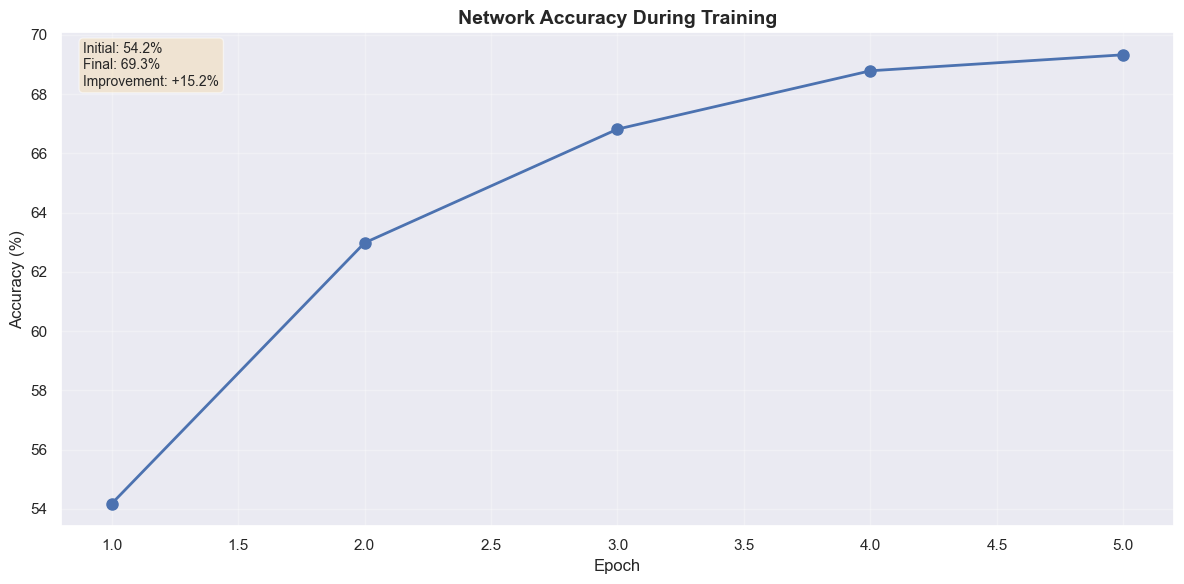

In [3]:
# Extract epoch end metrics
epoch_logs = [log for log in logs if log['type'] == 'epoch_end']

epochs = [log['epoch'] for log in epoch_logs]
accuracies = [log.get('accuracy_percent') for log in epoch_logs]

# Plot accuracy progression
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Network Accuracy During Training', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Highlight improvement
if accuracies:
    improvement = accuracies[-1] - accuracies[0]
    plt.text(0.02, 0.98, f'Initial: {accuracies[0]:.1f}%\nFinal: {accuracies[-1]:.1f}%\nImprovement: +{improvement:.1f}%',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 2. Weight Evolution: How Weights Change

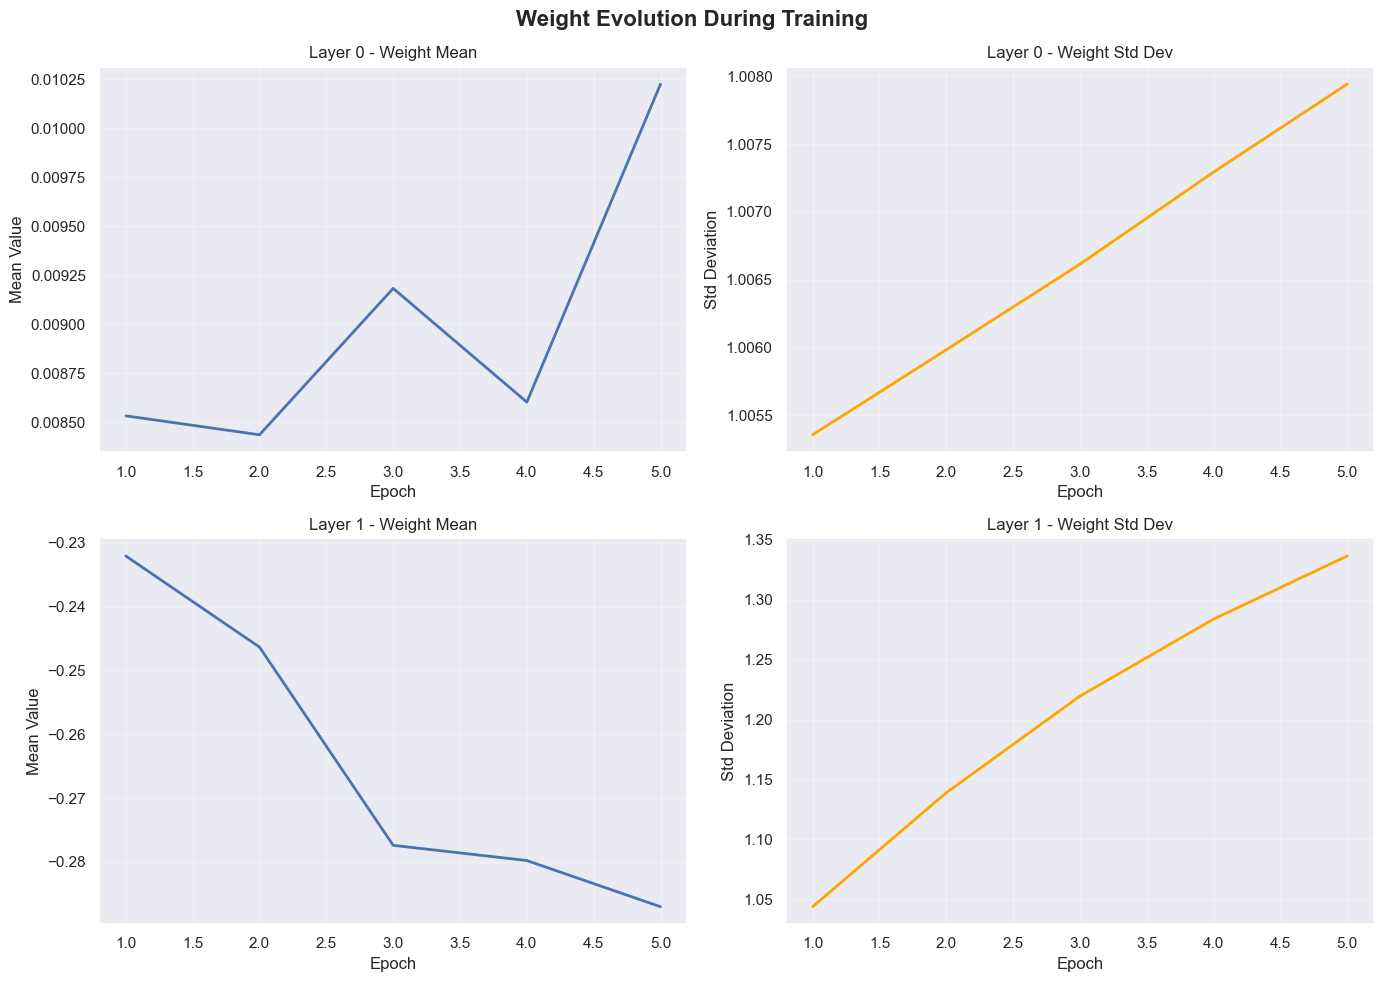

In [4]:
# Extract weight snapshots
weight_logs = [log for log in logs if log['type'] == 'weight_snapshot']

# Track weight statistics per layer over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Weight Evolution During Training', fontsize=16, fontweight='bold')

if weight_logs:
    num_layers = len(weight_logs[0]['layers'])
    
    for layer_idx in range(min(num_layers, 2)):  # Show first 2 layers
        epochs_w = [log['epoch'] for log in weight_logs]
        
        # Weight mean
        weight_means = [log['layers'][layer_idx]['weight_mean'] for log in weight_logs]
        axes[layer_idx, 0].plot(epochs_w, weight_means, linewidth=2)
        axes[layer_idx, 0].set_title(f'Layer {layer_idx} - Weight Mean')
        axes[layer_idx, 0].set_xlabel('Epoch')
        axes[layer_idx, 0].set_ylabel('Mean Value')
        axes[layer_idx, 0].grid(True, alpha=0.3)
        
        # Weight std
        weight_stds = [log['layers'][layer_idx]['weight_std'] for log in weight_logs]
        axes[layer_idx, 1].plot(epochs_w, weight_stds, linewidth=2, color='orange')
        axes[layer_idx, 1].set_title(f'Layer {layer_idx} - Weight Std Dev')
        axes[layer_idx, 1].set_xlabel('Epoch')
        axes[layer_idx, 1].set_ylabel('Std Deviation')
        axes[layer_idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Gradient Magnitudes: Learning Rate Insight

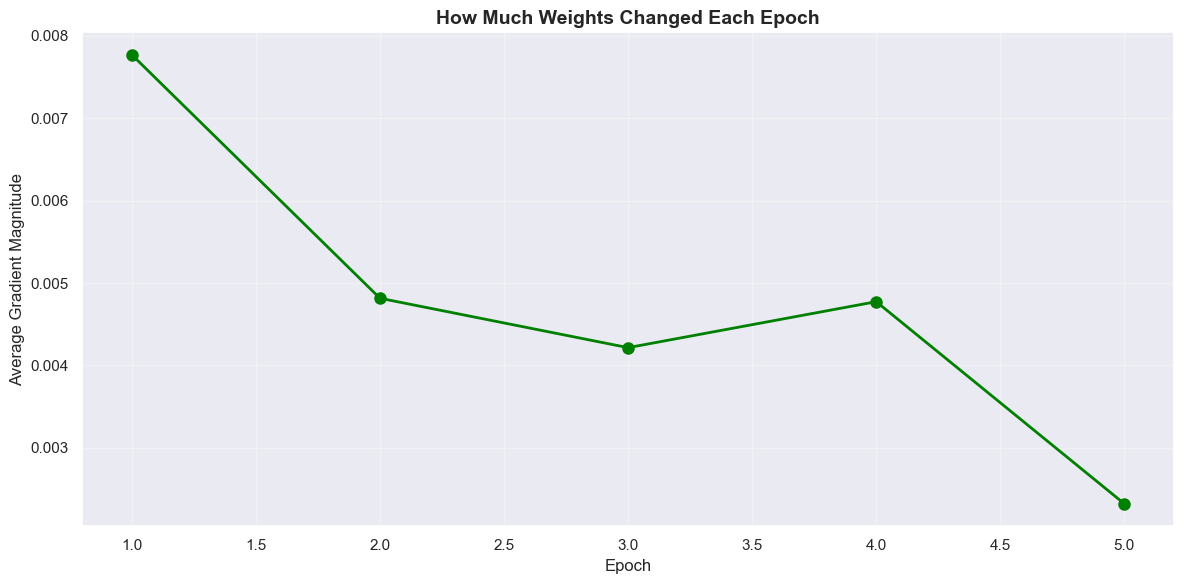

💡 Large gradients = big changes, small gradients = fine-tuning


In [5]:
# Extract mini-batch logs
batch_logs = [log for log in logs if log['type'] == 'mini_batch']

if batch_logs:
    # Group by epoch
    epochs_unique = sorted(set(log['epoch'] for log in batch_logs))
    
    # Average gradient magnitude per epoch
    grad_by_epoch = {}
    for epoch in epochs_unique:
        epoch_batches = [log for log in batch_logs if log['epoch'] == epoch]
        avg_weight_grad = np.mean([np.mean(log['gradient_stats']['weight_mean']) for log in epoch_batches])
        grad_by_epoch[epoch] = avg_weight_grad
    
    plt.figure(figsize=(12, 6))
    plt.plot(list(grad_by_epoch.keys()), list(grad_by_epoch.values()), 
             marker='o', linewidth=2, markersize=8, color='green')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Gradient Magnitude', fontsize=12)
    plt.title('How Much Weights Changed Each Epoch', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("💡 Large gradients = big changes, small gradients = fine-tuning")
else:
    print("No gradient data logged")

## 4. Training Time Analysis

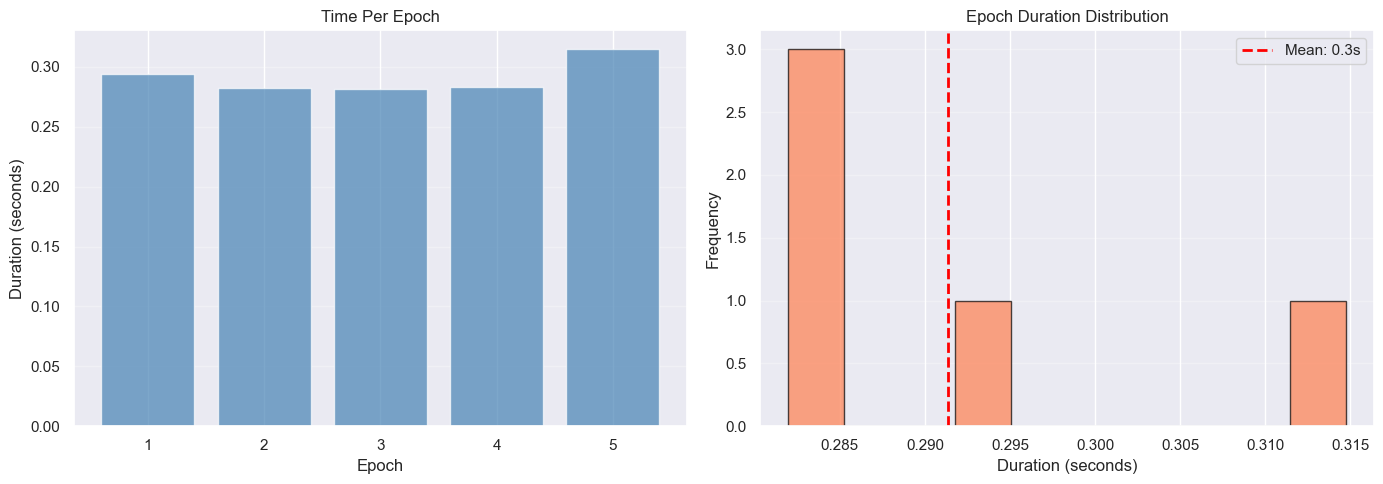

⏱️  Total training time: 1.5 seconds (0.0 minutes)
📊 Average per epoch: 0.3 seconds


In [6]:
if epoch_logs:
    durations = [log['duration_seconds'] for log in epoch_logs]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Time per epoch
    ax1.bar(epochs, durations, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Duration (seconds)')
    ax1.set_title('Time Per Epoch')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Distribution
    ax2.hist(durations, bins=10, color='coral', alpha=0.7, edgecolor='black')
    ax2.axvline(np.mean(durations), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(durations):.1f}s')
    ax2.set_xlabel('Duration (seconds)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Epoch Duration Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    total_time = sum(durations)
    print(f"⏱️  Total training time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print(f"📊 Average per epoch: {np.mean(durations):.1f} seconds")

## 5. Summary Statistics

In [7]:
completion_log = [log for log in logs if log['type'] == 'training_complete']

if completion_log and epoch_logs:
    print("═" * 50)
    print("📋 TRAINING SUMMARY")
    print("═" * 50)
    print(f"Session ID: {completion_log[0]['session_id']}")
    print(f"Total Epochs: {len(epoch_logs)}")
    print(f"Total Duration: {completion_log[0]['total_duration_seconds']:.1f}s")
    print()
    print(f"Initial Accuracy: {accuracies[0]:.2f}%")
    print(f"Final Accuracy: {accuracies[-1]:.2f}%")
    print(f"Best Accuracy: {max(accuracies):.2f}%")
    print(f"Improvement: +{accuracies[-1] - accuracies[0]:.2f}%")
    print("═" * 50)

══════════════════════════════════════════════════
📋 TRAINING SUMMARY
══════════════════════════════════════════════════
Session ID: 20251113_201240
Total Epochs: 5
Total Duration: 2.0s

Initial Accuracy: 54.17%
Final Accuracy: 69.33%
Best Accuracy: 69.33%
Improvement: +15.16%
══════════════════════════════════════════════════


## 6. Custom Analysis

Explore the logs yourself:

In [8]:
# Available log types
log_types = set(log['type'] for log in logs)
print("Available log types:", log_types)

# Example: Look at first epoch_end log
first_epoch = [log for log in logs if log['type'] == 'epoch_end'][0]
print("\nFirst epoch data:")
print(json.dumps(first_epoch, indent=2))

Available log types: {'mini_batch', 'epoch_start', 'weight_snapshot', 'epoch_end', 'training_complete'}

First epoch data:
{
  "type": "epoch_end",
  "timestamp": "2025-11-13T20:12:40.452131",
  "epoch": 1,
  "test_accuracy": 5417,
  "test_total": 10000,
  "accuracy_percent": 54.169999999999995,
  "duration_seconds": 0.294158935546875
}
